In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')

# 1. 학습 설정

In [2]:
config = {

    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로
    'model_path' : "../model", # 모델 저장 경로
    'model_name' : 'SASRec_v1.pt',

    'max_len' : 50,
    'hidden_units' : 50, # Embedding size
    'num_heads' : 1, # Multi-head layer 의 수 (병렬 처리)
    'num_layers': 2, # block의 개수 (encoder layer의 개수)
    'dropout_rate' : 0.5, # dropout 비율
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 200,
    'num_workers' : 2,

}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [3]:
if not os.path.isdir(config.model_path):
    os.mkdir(config.model_path)

# 2. 데이터 전처리

In [4]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x] + 1) # padding 고려
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'time']) # 시간에 따라 정렬
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템을 예측

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [5]:
class SASRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        
        user_seq = self.user_train[user]

        seq = np.zeros([self.max_len], dtype=np.int32)
        pos = np.zeros([self.max_len], dtype=np.int32)
        neg = np.zeros([self.max_len], dtype=np.int32)
        nxt = user_seq[-1]
        idx = self.max_len - 1

        for pos_sample in reversed(user_seq[:-1]):
            seq[idx] = pos_sample
            pos[idx] = nxt
            if nxt != 0: # padding이 아니라면
                neg[idx] = self.random_neg_sampling(user_seq)
            nxt = pos_sample
            idx -= 1
            if idx == -1: break
        
        return seq, pos, neg

    def random_neg_sampling(self, rated_item : list):
        nge_sample = np.random.randint(1, self.num_item + 1)
        while nge_sample in rated_item:
            nge_sample = np.random.randint(1, self.num_item + 1)
        return nge_sample

# 3. 모델

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate) # TODO1: dropout rate를 hyper parameter로 사용하여 dropout layer를 구현하세요.

    def forward(self, Q, K, V, mask):
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate) # TODO2: ScaledDotProductAttention class를 사용하여 attention layer를 구현하세요.
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)
        
        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) 
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        output, attn_dist = self.attention(Q, K, V, mask)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() 
        output = output.view(batch_size, seqlen, -1)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class SASRecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(SASRecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class SASRec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(SASRec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx=0) # TODO3: item embedding을 생성하세요. (padding index 고려 필요)
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([SASRecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
    
    def feats(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device))
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))
        seqs = self.emb_layernorm(self.dropout(seqs))
        
        # masking 
        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).unsqueeze(1) # TODO4: log_seqs=0인 경우 masking이 필요합니다. 해당 조건을 만족하는 mask를 구현하세요.
        # 참고 unsqueeze operation을 통해 mask_pad와 mask_time의 차원을 맞춰주는 과정이 필요합니다.        
        mask_time = (1 - torch.triu(torch.ones((1, 1, seqs.size(1), seqs.size(1))), diagonal=1)).bool() # sequence의 순서를 고려
        mask = (mask_pad & mask_time).to(self.device)
        for block in self.blocks: 
            seqs, attn_dist = block(seqs, mask)
        return seqs
    
    def forward(self, log_seqs, pos_seqs, neg_seqs):
        # 학습에 사용 
        feats = self.feats(log_seqs) # TODO5: Transformer를 사용해서 token 별 연산을 수행하세요.
        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.device))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.device))
        
        pos_logits = (feats * pos_embs).sum(dim=-1)
        neg_logits = (feats * neg_embs).sum(dim=-1)
        return pos_logits, neg_logits
    
    def predict(self, log_seqs, item_indices):
        # evaluation에 사용
        final_feats = self.feats(log_seqs)[:, -1, :]
        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.device))
        logits = item_embs.matmul(final_feats.unsqueeze(-1)).squeeze(-1)
        return logits

# 4. 학습 함수

In [7]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, pos, neg in data_loader:
        pos_logits, neg_logits = model(seq.cpu().numpy(), pos.cpu().numpy(), neg.cpu().numpy())
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=device), torch.zeros(neg_logits.shape, device=device)

        optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, sasrec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100
    num_user_sample = 1000

    users = np.random.randint(0, make_sequence_dataset.num_user, num_user_sample) # 1000개만 sampling 하여 evaluation
    for user in users:
        seq = user_train[user][-max_len:]
        rated = set(user_train[user] + user_valid[user])
        item_idx = user_valid[user] + [sasrec_dataset.random_neg_sampling(rated) for _ in range(num_item_sample)]
        with torch.no_grad():
            predictions = -model.predict(np.array([seq]), np.array(item_idx))
            predictions = predictions[0]
            rank = predictions.argsort().argsort()[0].item()

        if rank < 10: # @10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= num_user_sample
    HIT /= num_user_sample

    return NDCG, HIT

# 5.학습

In [8]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [9]:
sasrec_dataset = SASRecDataSet(
    user_train = user_train, 
    max_len = config.max_len, 
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    )

In [10]:
data_loader = DataLoader(
    sasrec_dataset, 
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [11]:
model = SASRec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = config.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
best_ndcg = 0
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader)
        
        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid, 
            max_len = config.max_len,
            sasrec_dataset = sasrec_dataset, 
            make_sequence_dataset = make_sequence_dataset,
            )

        if best_ndcg < ndcg:
            best_ndcg = ndcg
            torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name))

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 3.63382| NDCG@10: 0.12113| HIT@10: 0.26000: 100%|██████████| 1/1 [00:08<00:00,  8.43s/it]
Epoch:   2| Train loss: 1.56680| NDCG@10: 0.26407| HIT@10: 0.49500: 100%|██████████| 1/1 [00:09<00:00,  9.59s/it]
Epoch:   3| Train loss: 1.11407| NDCG@10: 0.35376| HIT@10: 0.59000: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]
Epoch:   4| Train loss: 0.97106| NDCG@10: 0.35389| HIT@10: 0.61700: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]
Epoch:   5| Train loss: 0.92454| NDCG@10: 0.34137| HIT@10: 0.59600: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]
Epoch:   6| Train loss: 0.90703| NDCG@10: 0.34259| HIT@10: 0.59800: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]
Epoch:   7| Train loss: 0.89929| NDCG@10: 0.35507| HIT@10: 0.60600: 100%|██████████| 1/1 [00:08<00:00,  8.63s/it]
Epoch:   8| Train loss: 0.89443| NDCG@10: 0.36741| HIT@10: 0.61700: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]
Epoch:   9| Train loss: 0.89128| NDCG@10: 0.34770| HIT@10: 0.60900: 100%|██████████| 1/1

# 6.임베딩 시각화

In [24]:
item_emb = model.item_emb.weight[1:].data.cpu().numpy()

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(item_emb)

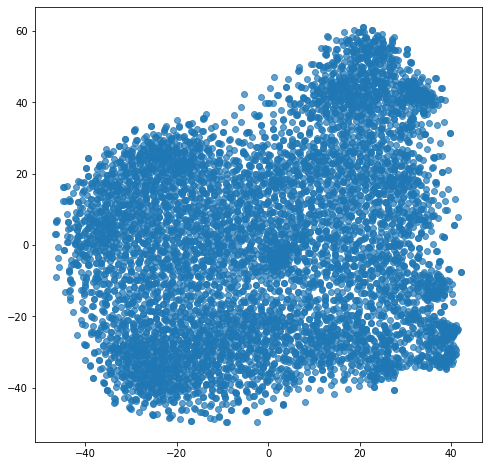

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()